In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

cuda


Read dataset and basic preprocessing

In [4]:
# reading data from my google drive

data_df = pd.read_csv('/content/drive/MyDrive/Datasets/riceClassification.csv') # change path to your own drive location
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


we are removing null/na values from the dataset as they are not helpful. also removing the id column which is not required for the training.

In [5]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True)
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [6]:
print(data_df["Class"].unique())

[1 0]


In [7]:
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


NORMALIZATION

In [8]:
original_df = data_df.copy()

In [9]:
for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

In [10]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [11]:
X = np.array(data_df.iloc[:, :-1])
Y = np.array(data_df.iloc[:, -1])

## Preparing Training, Validation and Testing datasets

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [13]:
# validation dataset is created from testing dataset to not reduce training data
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


## Model Setup

In [15]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device) # converting the inputs which are floats to tensors for pytorch to use
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device) # always need to use to.(device) so that its saved into the GPU

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx] # basically returns the whole data row

In [16]:
training_data = dataset(X_train, Y_train)
testing_data = dataset(X_test, Y_test)
validation_data = dataset(X_val, Y_val)

In [17]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=32, shuffle=True)

creating the model

In [18]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

In [19]:
model = MyModel().to(device)

In [20]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


loss function and optimizer

```
# This is formatted as code
```



In [21]:
loss_func = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

## Training and Validation

In [22]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

epochs = 10
for epoch in range(epochs):
  total_acc_train = 0
  total_acc_val = 0
  total_loss_train = 0
  total_loss_val = 0

  for data in train_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1) # squeeze changes the dimension of the prediction to fit the loss function

    batch_loss = loss_func(prediction, labels)
    total_loss_train += batch_loss.item()

    acc = prediction.round() == labels
    total_acc_train += acc.sum().item()

    # backpropagation
    batch_loss.backward()
    # do a step on the weights
    optimizer.step()
    # reset the optimizer gradients
    optimizer.zero_grad()

  with torch.no_grad(): # this is for when we need to test the model (validation or testing phase)
    for data in val_dataloader:
      inputs, labels = data
      prediction = model(inputs).squeeze(1)

      batch_loss = loss_func(prediction, labels)
      total_loss_val += batch_loss.item()

      acc = prediction.round() == labels
      total_acc_val += acc.sum().item()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_val_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
  total_acc_val_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))

  print(f'''Epoch {epoch+1}
        Train Loss : {round(total_loss_train/1000, 4)}, Train Accuracy : {round(total_acc_train/training_data.__len__() * 100, 4)}
        Validation Loss : {round(total_loss_val/1000, 4)}, Validation Accuracy : {round(total_acc_val/validation_data.__len__() * 100, 4)}''')

  print("="*25)

Epoch 1
        Train Loss : 0.2431, Train Accuracy : 78.7022
        Validation Loss : 0.0404, Validation Accuracy : 98.3871
Epoch 2
        Train Loss : 0.1291, Train Accuracy : 98.1695
        Validation Loss : 0.0182, Validation Accuracy : 98.3138
Epoch 3
        Train Loss : 0.0622, Train Accuracy : 98.4131
        Validation Loss : 0.0103, Validation Accuracy : 98.827
Epoch 4
        Train Loss : 0.0388, Train Accuracy : 98.5388
        Validation Loss : 0.0071, Validation Accuracy : 98.607
Epoch 5
        Train Loss : 0.0294, Train Accuracy : 98.5702
        Validation Loss : 0.0056, Validation Accuracy : 98.4604
Epoch 6
        Train Loss : 0.0245, Train Accuracy : 98.6645
        Validation Loss : 0.0048, Validation Accuracy : 98.6804
Epoch 7
        Train Loss : 0.0217, Train Accuracy : 98.5702
        Validation Loss : 0.0044, Validation Accuracy : 98.827
Epoch 8
        Train Loss : 0.0202, Train Accuracy : 98.5859
        Validation Loss : 0.0041, Validation Accuracy : 98.

## Testing

In [23]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)

    batch_loss = loss_func(prediction, labels)
    total_loss_test += batch_loss.item()

    acc = prediction.round() == labels
    total_acc_test += acc.sum().item()

print(f'''Test Loss : {round(total_loss_test/1000, 4)}, Test Accuracy : {round(total_acc_test/testing_data.__len__() * 100, 4)}''')

Test Loss : 0.0042, Test Accuracy : 98.3871


## Plotting Loss and Accuracy graphs

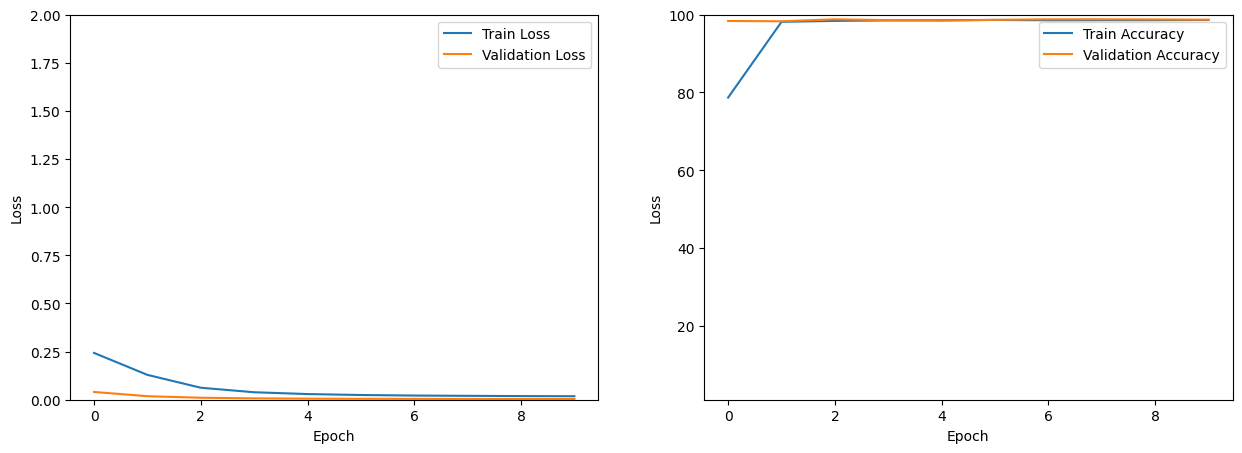

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Train Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(0, 2)
axs[0].legend()


axs[1].plot(total_acc_train_plot, label='Train Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_ylim(1, 100)
axs[1].legend()

plt.show()

# Inference
Checking model performance with user inputs

In [25]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

Area: 234
Major Axis Length: 23
Minor Axis Length: 54
Eccentricity: 34
Convex Area: 54
EquivDiameter: 56
Extent: 23
Perimeter: 43
Roundness: 567
AspectRation: 324
tensor([0.], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  0
